In [56]:
import sklearn
print(sklearn.__version__)

1.3.2


In [89]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [90]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [91]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999


In [74]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.20
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


d = 45
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,1.0


In [75]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target_verify(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 45
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,1.0,0.494478,1.0


In [76]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_30'] = price_data.groupby('Ticker')['Close'].shift(-30)
price_data['Smoothed_Close_30'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-30)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [77]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0,0.599993,0.574836
5706,2024-11-19,12.450000,12.600000,12.420000,12.430000,12.191905,28564100,ABEV3.SA,0.010000,12.549591,NaN,12.430000,NaN,11.540000,11.827934
5707,2024-11-21,12.310000,12.480000,12.300000,12.390000,12.152671,18400700,ABEV3.SA,-0.040000,12.517673,NaN,12.390000,NaN,11.420000,11.746347
5708,2024-11-22,12.490000,12.700000,12.470000,12.680000,12.437116,24116600,ABEV3.SA,0.290000,12.550138,NaN,12.680000,NaN,11.400000,11.677078
5709,2024-11-25,12.590000,12.690000,12.540000,12.540000,12.299797,22015800,ABEV3.SA,-0.140000,12.548111,NaN,12.540000,NaN,11.160000,11.573662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [78]:
# Período do indicador.
n = 12

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,62.711366
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.309669
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,38.599510
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,49.523297
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.823817


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [79]:
t = 14
low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,62.711366,50.869999,55.099998,57.575879
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.309669,50.869999,54.490002,63.711767
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,38.599510,50.869999,54.490002,58.980461
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,49.523297,50.869999,54.490002,59.118061
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.823817,50.869999,54.490002,58.565163


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [80]:
# Período de cálculo do indicador
t = 14

low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)

price_data[f'r_percent_{t}'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,62.711366,50.869999,55.099998,57.575879,-42.424121
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.309669,50.869999,54.490002,63.711767,-36.288233
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,38.599510,50.869999,54.490002,58.980461,-41.019539
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,49.523297,50.869999,54.490002,59.118061,-40.881939
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.823817,50.869999,54.490002,58.565163,-41.434837


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [81]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,62.711366,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.309669,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,38.599510,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,49.523297,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.823817,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [82]:
# Período do indicador
e = 14

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,62.711366,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.033897
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.309669,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.032992
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,38.599510,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.029930
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,49.523297,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.022394
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.823817,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.014863


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [83]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,62.711366,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.033897,2329297670
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.309669,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.032992,2294652270
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,38.599510,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.029930,2269554970
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,49.523297,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.022394,2290075570
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.823817,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.014863,2288822970


#### Salvando antes de tirar os Nans.

In [84]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.parquet', index=False)

In [85]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.xlsx', index=False)

## Removendo Nans

In [86]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.tail()

Antes de tirar as NaN nós tinhamos 27044 linhas e 26 colunas
Depois da retirada dos NaN temos 26749 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11734,2024-11-11,59.750000,59.869999,58.650002,58.650002,58.131153,24483700,VALE3.SA,-1.980000,61.254148,-1.0,58.650002,-1.0,54.740002,55.332221,1.980000,0.000000,30.645048,58.650002,63.990002,48.766795,-51.233205,0.318598,0.382283,0.003339,2569015870
11735,2024-11-12,58.580002,58.590000,57.200001,57.320000,56.812916,26967600,VALE3.SA,-1.330002,60.467319,-1.0,57.320000,-1.0,54.549999,55.175777,1.330002,0.000000,25.764399,57.200001,63.990002,48.119551,-51.880449,0.198989,0.345624,-0.004002,2542048270
11736,2024-11-13,57.320000,57.720001,57.110001,57.160000,56.654331,20354900,VALE3.SA,-0.160000,59.805855,-1.0,57.160000,-1.0,54.250000,54.990622,0.160000,0.000000,25.193931,57.110001,63.990002,39.183923,-60.816077,0.050244,0.286548,-0.011608,2521693370
11737,2024-11-14,57.160000,57.340000,56.840000,56.840000,56.337162,17967600,VALE3.SA,-0.320000,59.212684,-1.0,56.840000,-1.0,53.240002,54.640498,0.320000,0.000000,23.940981,56.840000,63.990002,33.184382,-66.815618,-0.114185,0.206402,-0.025347,2503725770
11738,2024-11-18,57.090000,57.779999,56.970001,57.549999,57.040882,14300000,VALE3.SA,0.709999,58.880147,-1.0,57.549999,-1.0,52.560001,54.224398,0.000000,0.709999,32.715294,56.840000,63.990002,28.533517,-71.466483,-0.268237,0.111474,-0.037561,2489425770


## VALIDAÇÃO

### Geral

In [16]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 220, oob_score = True, criterion = "gini", random_state = 0, n_jobs=-1)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  74.92890285885346


In [227]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 84.14%


In [53]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [87]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
5701,2024-11-11,12.31,12.55,12.26,12.51,12.270372,20684800,ABEV3.SA,0.180000,12.586564,-1.0,12.51,-1.0,12.07,12.554056,0.000000,0.18,40.855360,12.26,13.09,39.345088,-60.654912,-0.081478,-0.033515,-0.032029,-2321489347
5702,2024-11-12,12.43,12.64,12.30,12.58,12.339031,26899600,ABEV3.SA,0.070000,12.585252,-1.0,12.58,-1.0,11.74,12.391245,0.000000,0.07,46.329567,12.26,13.09,39.186907,-60.813093,-0.089866,-0.044785,-0.029547,-2348388947
5703,2024-11-13,12.52,12.77,12.46,12.73,12.486157,30341700,ABEV3.SA,0.150000,12.614201,-1.0,12.73,-1.0,11.60,12.232996,0.000000,0.15,56.520901,12.26,13.09,42.674811,-57.325189,-0.093104,-0.054449,-0.025083,-2318047247
5704,2024-11-14,12.69,12.90,12.61,12.64,12.397882,38027500,ABEV3.SA,-0.089999,12.619361,-1.0,12.64,-1.0,11.33,12.052397,0.089999,0.00,49.813665,12.26,13.09,43.296479,-56.703521,-0.094169,-0.062393,-0.023042,-2280019747
5705,2024-11-18,12.48,12.67,12.38,12.42,12.182096,37251000,ABEV3.SA,-0.220000,12.579489,-1.0,12.42,-1.0,11.29,11.899917,0.220000,0.00,37.096230,12.26,13.09,38.492602,-61.507398,-0.097111,-0.069337,-0.025722,-2317270747


In [88]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")



Fold 1:
  Accuracy with Y_test (Prediction): 0.5232
  Accuracy with Verify: 0.5200
Fold 2:
  Accuracy with Y_test (Prediction): 0.4314
  Accuracy with Verify: 0.4304
Fold 3:
  Accuracy with Y_test (Prediction): 0.5928
  Accuracy with Verify: 0.5981
Fold 4:
  Accuracy with Y_test (Prediction): 0.6129
  Accuracy with Verify: 0.5949
Fold 5:
  Accuracy with Y_test (Prediction): 0.4905
  Accuracy with Verify: 0.4852

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5302
  Média da acurácia com Verify: 0.5257


#### Walk-Forward Validation

In [228]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]


In [229]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.6056
  Accuracy with Verify: 0.6389
Window 2:
  Accuracy with Y_test (Prediction): 0.2278
  Accuracy with Verify: 0.1944
Window 3:
  Accuracy with Y_test (Prediction): 0.7556
  Accuracy with Verify: 0.7167
Window 4:
  Accuracy with Y_test (Prediction): 0.5944
  Accuracy with Verify: 0.5889
Window 5:
  Accuracy with Y_test (Prediction): 0.7111
  Accuracy with Verify: 0.5778
Window 6:
  Accuracy with Y_test (Prediction): 0.8500
  Accuracy with Verify: 0.8278
Window 7:
  Accuracy with Y_test (Prediction): 0.4889
  Accuracy with Verify: 0.4500
Window 8:
  Accuracy with Y_test (Prediction): 0.3333
  Accuracy with Verify: 0.3389
Window 9:
  Accuracy with Y_test (Prediction): 0.2667
  Accuracy with Verify: 0.2833
Window 10:
  Accuracy with Y_test (Prediction): 0.5111
  Accuracy with Verify: 0.4556
Window 11:
  Accuracy with Y_test (Prediction): 0.5833
  Accuracy with Verify: 0.5556
Window 12:
  Accuracy with Y_test (Prediction): 0.4444
  Accura

#### Split normal sem cross-validation.

In [230]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [231]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators = 220, oob_score = True, criterion = "gini", random_state = 0, max_depth= None, max_samples=None, max_leaf_nodes=None,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Ambev.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Ambev.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  82.18793828892007


In [232]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.807453,0.707804,0.754352,551.000000
Up Day,0.829268,0.893714,0.860286,875.000000
accuracy,0.821879,0.821879,0.821879,0.821879
macro avg,0.818361,0.800759,0.807319,1426.000000
weighted avg,0.820839,0.821879,0.819354,1426.000000


Accuracy: 0.8218793828892006
Precision: 0.8292682926829268
Recall: 0.8937142857142857
Specificity: 0.7078039927404719
F1-Score: 0.8603


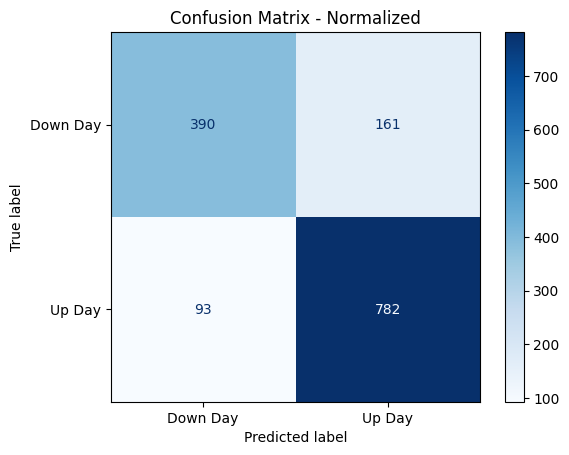

In [233]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


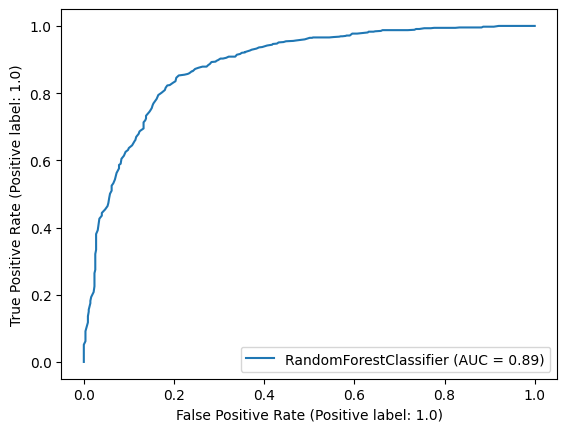

In [234]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para AMBEV.

In [84]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [ ]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Utilizando a verificação da predicação com o preço real e não suavizado.

In [235]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 80.87%

Precisão do modelo nos últimos 30 dias: 90.00%


#### Plotagem:

In [236]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

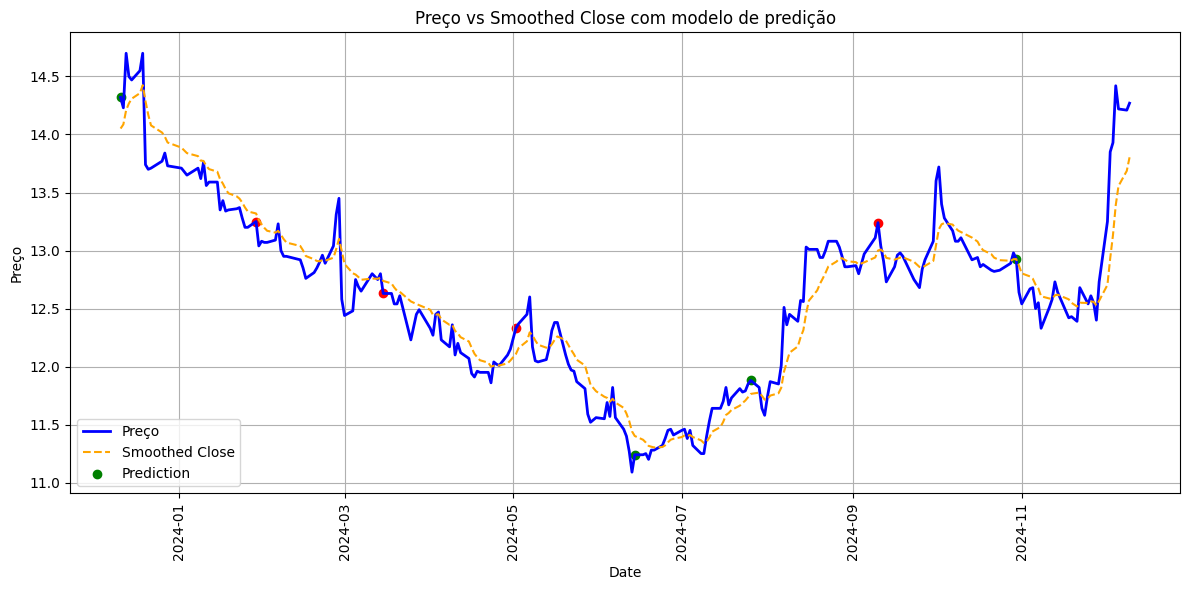

In [237]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [238]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17884,2001-01-22,3.328138,3.328138,3.190707,3.212232,1.842811,39666861,ITUB4.SA,-0.115906,3.183127,-1.0,3.212232,-1.0,3.046653,2.982868,0.115906,0.000000,58.840366,2.947306,3.377811,54.777677,-45.222323,0.032415,0.017661,0.075180,1034153537,1
17885,2001-01-23,3.212232,3.245348,3.182594,3.182594,1.825808,95181141,ITUB4.SA,-0.029638,3.183020,-1.0,3.182594,-1.0,2.980422,2.982379,0.029638,0.000000,54.479523,3.046653,3.377811,41.178855,-58.821145,0.034654,0.021060,0.084546,938972396,1
17886,2001-01-24,3.228790,3.228790,3.094506,3.094506,1.775270,72183058,ITUB4.SA,-0.088088,3.165317,-1.0,3.094506,-1.0,2.844647,2.954832,0.088088,0.000000,43.438992,3.046653,3.377811,35.833125,-64.166875,0.034786,0.023805,0.086174,866789338,1
17887,2001-01-26,3.096327,3.212232,3.096162,3.179117,1.823813,105025383,ITUB4.SA,0.084611,3.168077,-1.0,3.179117,-1.0,2.798285,2.923523,0.000000,0.084611,53.812753,3.046653,3.377811,36.666546,-63.333454,0.034664,0.025977,0.086134,971814721,1
17888,2001-01-29,3.195675,3.195675,3.121164,3.129443,1.795315,78053367,ITUB4.SA,-0.049674,3.160350,-1.0,3.129443,-1.0,2.798285,2.898475,0.049674,0.000000,47.865791,3.046653,3.377811,34.333262,-65.666738,0.033629,0.027507,0.072718,893761354,1


In [239]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220 , oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.65
  Accuracy with Verify: 0.56
Fold 2:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.55
Fold 3:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.54
Fold 4:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.56
Fold 5:
  Accuracy with Y_test (Prediction): 0.63
  Accuracy with Verify: 0.58

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.59
  Média da acurácia com Verify: 0.56

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0    -1.0
1            1.0              1.0    -1.0
2            1.0              1.0    -1.0
3            1.0              1.0    -1.0
4            1.0             -1.0    -1.0
...          ...              ...     ...
4825        -1.0             -1.0     1.0
4826        -1.0             -1.0    -1.0
4827        -1.0             -1.0    -1.0
4828        -1.0             -1.0    -1.0
4829        -1.0    

#### Walk-Forward Validation

In [240]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [241]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4500
  Accuracy with Verify: 0.3944
Window 2:
  Accuracy with Y_test (Prediction): 0.3611
  Accuracy with Verify: 0.3333
Window 3:
  Accuracy with Y_test (Prediction): 0.3833
  Accuracy with Verify: 0.3833
Window 4:
  Accuracy with Y_test (Prediction): 0.6222
  Accuracy with Verify: 0.5778
Window 5:
  Accuracy with Y_test (Prediction): 0.6778
  Accuracy with Verify: 0.6722
Window 6:
  Accuracy with Y_test (Prediction): 0.7611
  Accuracy with Verify: 0.6889
Window 7:
  Accuracy with Y_test (Prediction): 0.5222
  Accuracy with Verify: 0.4611
Window 8:
  Accuracy with Y_test (Prediction): 0.5722
  Accuracy with Verify: 0.4722
Window 9:
  Accuracy with Y_test (Prediction): 0.5833
  Accuracy with Verify: 0.4722
Window 10:
  Accuracy with Y_test (Prediction): 0.3444
  Accuracy with Verify: 0.3444
Window 11:
  Accuracy with Y_test (Prediction): 0.7056
  Accuracy with Verify: 0.6833
Window 12:
  Accuracy with Y_test (Prediction): 0.5778
  Accura

#### Split normal sem cross-validation.

In [242]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [243]:
# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators = 220, oob_score = True, criterion = "gini", random_state = 0,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Itau.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Itau.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Itau.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  81.79310344827586


In [244]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.804270,0.745875,0.773973,606.000000
Up Day,0.826577,0.869668,0.847575,844.000000
accuracy,0.817931,0.817931,0.817931,0.817931
macro avg,0.815424,0.807771,0.810774,1450.000000
weighted avg,0.817254,0.817931,0.816814,1450.000000


Accuracy: 0.8179310344827586
Precision: 0.8265765765765766
Recall: 0.8696682464454977
Specificity: 0.7458745874587459
F1-Score: 0.8476


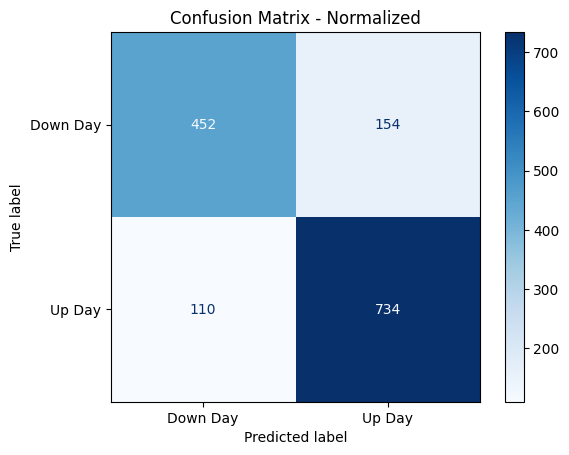

In [245]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


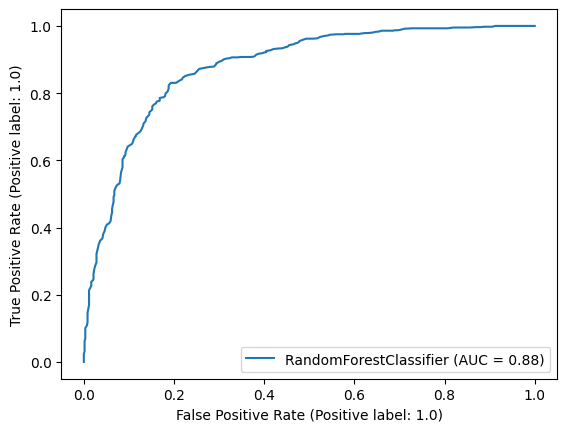

In [246]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para ITAU.

In [247]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [248]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Itau['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
overall_accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 81.32%

Precisão do modelo nos últimos 30 dias: 85.00%


#### Plotagem:

In [290]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

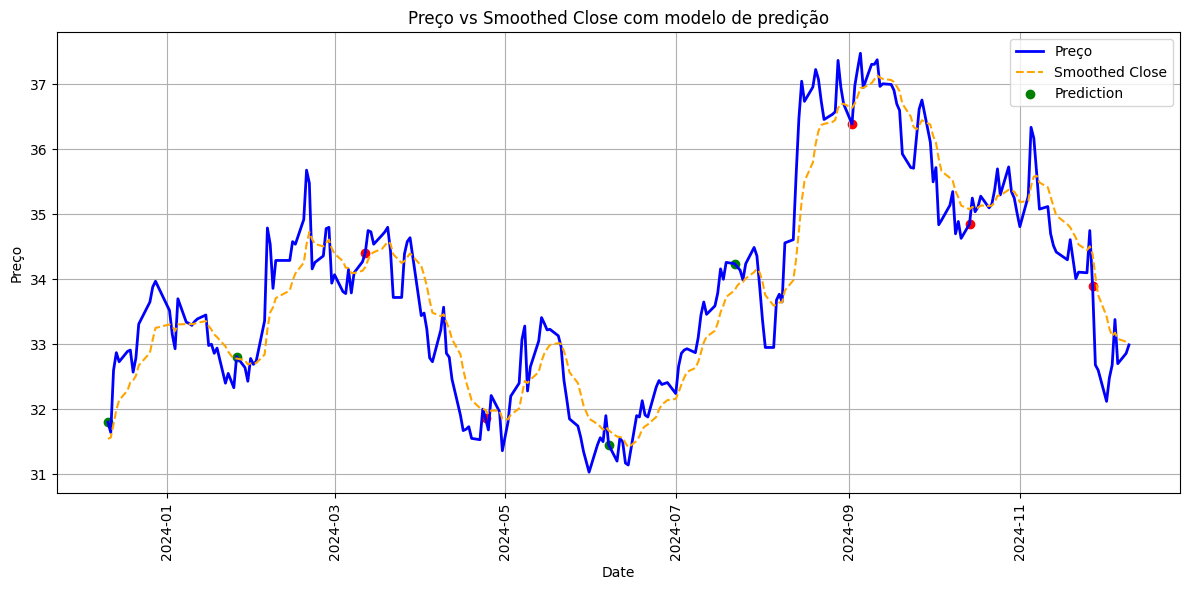

In [291]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [251]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
23731,2011-05-31,4.676616,4.676616,4.574315,4.676616,4.307227,3846883,MGLU3.SA,0.014614,4.637045,1.0,4.676616,-1.0,4.603544,4.707241,0.0,0.014614,53.311868,4.43694,4.822760,51.864741,-48.135259,-0.027713,-0.024024,-0.035586,-17479521,0
23732,2011-06-01,4.638619,4.755534,4.612313,4.735074,4.361068,1503309,MGLU3.SA,0.058458,4.656651,-1.0,4.735074,-1.0,4.384328,4.642659,0.0,0.058458,60.345428,4.43694,4.799377,60.620330,-39.379670,-0.025983,-0.024415,-0.029739,-15976212,1
23733,2011-06-02,4.676616,4.822760,4.676616,4.793532,4.414908,1482439,MGLU3.SA,0.058458,4.684027,1.0,4.793532,-1.0,4.238183,4.561763,0.0,0.058458,66.217696,4.43694,4.822760,64.041960,-35.958040,-0.022497,-0.024032,-0.024747,-14493773,0
23734,2011-06-03,4.735074,4.881218,4.735074,4.881218,4.495669,1386643,MGLU3.SA,0.087686,4.723465,-1.0,4.881218,-1.0,4.054042,4.460219,0.0,0.087686,73.109680,4.43694,4.881218,64.492280,-35.507720,-0.016847,-0.022595,-0.015913,-13107130,1
23735,2011-06-06,4.843221,4.916293,4.811069,4.881218,4.495669,1116362,MGLU3.SA,0.000000,4.755016,-1.0,4.881218,-1.0,4.325870,4.433349,0.0,0.000000,73.109680,4.43694,4.916293,66.355165,-33.644835,-0.010092,-0.020094,-0.007386,-11990768,1


In [252]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.6435
  Accuracy with Verify: 0.5978
Fold 2:
  Accuracy with Y_test (Prediction): 0.3711
  Accuracy with Verify: 0.3766
Fold 3:
  Accuracy with Y_test (Prediction): 0.5576
  Accuracy with Verify: 0.5704
Fold 4:
  Accuracy with Y_test (Prediction): 0.5064
  Accuracy with Verify: 0.4881
Fold 5:
  Accuracy with Y_test (Prediction): 0.5027
  Accuracy with Verify: 0.3473

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5163
  Média da acurácia com Verify: 0.4761

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0              1.0     1.0
1            1.0              1.0     1.0
2           -1.0              1.0     1.0
3           -1.0              1.0     1.0
4           -1.0              1.0     1.0
...          ...              ...     ...
2730        -1.0              1.0    -1.0
2731        -1.0              1.0    -1.0
2732        -1.0             -1.0    -1.0
2733         1.0             -1.0    -

#### Walk-Forward Validation

In [253]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [254]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.7056
  Accuracy with Verify: 0.6333
Window 2:
  Accuracy with Y_test (Prediction): 0.6278
  Accuracy with Verify: 0.5944
Window 3:
  Accuracy with Y_test (Prediction): 0.6889
  Accuracy with Verify: 0.6667
Window 4:
  Accuracy with Y_test (Prediction): 0.4667
  Accuracy with Verify: 0.5056
Window 5:
  Accuracy with Y_test (Prediction): 0.3222
  Accuracy with Verify: 0.3389
Window 6:
  Accuracy with Y_test (Prediction): 0.9167
  Accuracy with Verify: 0.8833
Window 7:
  Accuracy with Y_test (Prediction): 0.7667
  Accuracy with Verify: 0.7667
Window 8:
  Accuracy with Y_test (Prediction): 0.6722
  Accuracy with Verify: 0.6889
Window 9:
  Accuracy with Y_test (Prediction): 0.8167
  Accuracy with Verify: 0.7778
Window 10:
  Accuracy with Y_test (Prediction): 0.7389
  Accuracy with Verify: 0.7333
Window 11:
  Accuracy with Y_test (Prediction): 0.2444
  Accuracy with Verify: 0.2667
Window 12:
  Accuracy with Y_test (Prediction): 0.3389
  Accura

#### Split normal sem cross-validation.

In [255]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [256]:
# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators = 220, oob_score = True, criterion = "gini", random_state = 0,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Magalu.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Magalu.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Magalu.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  84.40925700365408


In [257]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.819629,0.837398,0.828418,369.000000
Up Day,0.864865,0.849558,0.857143,452.000000
accuracy,0.844093,0.844093,0.844093,0.844093
macro avg,0.842247,0.843478,0.842781,821.000000
weighted avg,0.844533,0.844093,0.844233,821.000000


Accuracy: 0.8440925700365408
Precision: 0.8648648648648649
Recall: 0.8495575221238938
Specificity: 0.8373983739837398
F1-Score: 0.8571


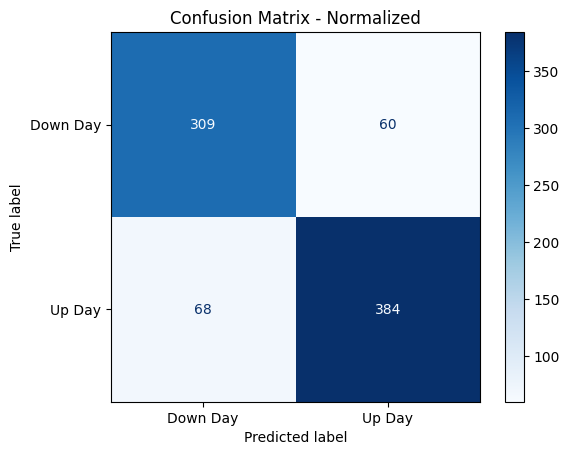

In [258]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


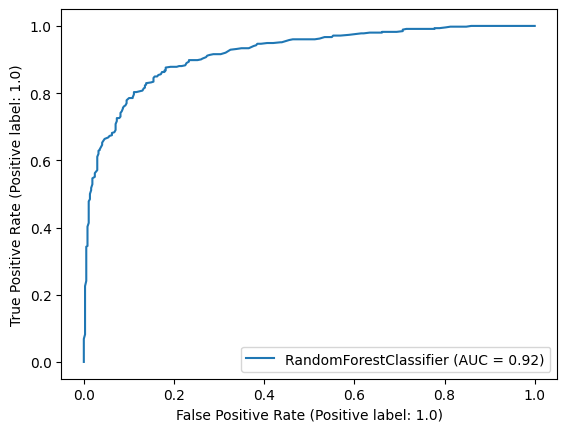

In [259]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para MAGALU.

In [87]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Magalu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [260]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 83.55%

Precisão do modelo nos últimos 30 dias: 90.48%


#### Plotagem:

In [263]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

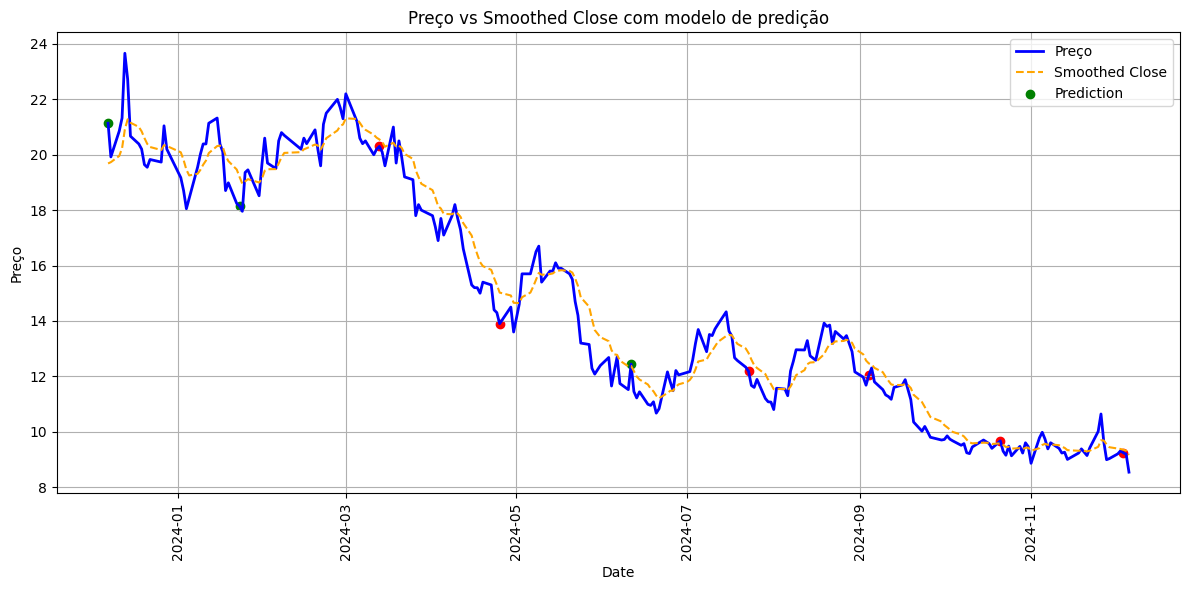

In [264]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [265]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17830,2024-12-04,39.500000,39.860001,38.980000,39.250000,36.389229,31584400,PETR4.SA,-0.250000,38.888980,1.0,39.250000,-1.0,37.299999,37.104151,0.250000,0.000000,66.767374,36.529999,39.860001,70.840239,-29.159761,0.584023,0.360703,0.086489,-150627253651,0
17831,2024-12-05,39.389999,39.810001,39.209999,39.639999,36.750801,25214200,PETR4.SA,0.389999,39.039184,-1.0,39.639999,-1.0,37.090000,37.101321,0.000000,0.389999,71.827634,36.860001,39.860001,72.639443,-27.360557,0.618615,0.412285,0.093087,-150602039451,1
17832,2024-12-06,39.639999,39.700001,38.959999,39.029999,36.185261,31118500,PETR4.SA,-0.610001,39.037347,-1.0,39.029999,-1.0,36.830002,37.047057,0.610001,0.000000,56.344078,37.200001,39.860001,69.073166,-30.926834,0.638521,0.457533,0.094290,-150633157951,1
17833,2024-12-09,39.380001,40.169998,39.360001,40.040001,37.121647,28548700,PETR4.SA,1.010002,39.237878,-1.0,40.040001,-1.0,36.639999,36.965646,0.000000,1.010002,69.078508,37.549999,40.169998,64.422868,-35.577132,0.662837,0.498594,0.096798,-150604609251,1
17834,2024-12-10,40.299999,40.430000,40.110001,40.189999,37.260712,21837600,PETR4.SA,0.149998,39.428302,-1.0,40.189999,-1.0,36.810001,36.934517,0.000000,0.149998,70.550562,37.549999,40.430000,65.218818,-34.781182,0.689525,0.536780,0.099201,-150582771651,1


In [267]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.6458
  Accuracy with Verify: 0.5751
Fold 2:
  Accuracy with Y_test (Prediction): 0.4587
  Accuracy with Verify: 0.4418
Fold 3:
  Accuracy with Y_test (Prediction): 0.5493
  Accuracy with Verify: 0.5214
Fold 4:
  Accuracy with Y_test (Prediction): 0.5453
  Accuracy with Verify: 0.4876
Fold 5:
  Accuracy with Y_test (Prediction): 0.5542
  Accuracy with Verify: 0.4945

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5506
  Média da acurácia com Verify: 0.5041

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0             -1.0    -1.0
1            1.0             -1.0    -1.0
2            1.0             -1.0    -1.0
3            1.0             -1.0    -1.0
4            1.0             -1.0    -1.0
...          ...              ...     ...
5020        -1.0              1.0    -1.0
5021        -1.0             -1.0    -1.0
5022        -1.0             -1.0    -1.0
5023        -1.0             -1.0    -

#### Walk-Forward Validation

In [268]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [269]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4889
  Accuracy with Verify: 0.5167
Window 2:
  Accuracy with Y_test (Prediction): 0.6111
  Accuracy with Verify: 0.6333
Window 3:
  Accuracy with Y_test (Prediction): 0.2333
  Accuracy with Verify: 0.2444
Window 4:
  Accuracy with Y_test (Prediction): 0.7111
  Accuracy with Verify: 0.6556
Window 5:
  Accuracy with Y_test (Prediction): 0.6222
  Accuracy with Verify: 0.5611
Window 6:
  Accuracy with Y_test (Prediction): 0.6278
  Accuracy with Verify: 0.5889
Window 7:
  Accuracy with Y_test (Prediction): 0.6778
  Accuracy with Verify: 0.5611
Window 8:
  Accuracy with Y_test (Prediction): 0.6833
  Accuracy with Verify: 0.5889
Window 9:
  Accuracy with Y_test (Prediction): 0.5167
  Accuracy with Verify: 0.4444
Window 10:
  Accuracy with Y_test (Prediction): 0.2667
  Accuracy with Verify: 0.3389
Window 11:
  Accuracy with Y_test (Prediction): 0.5333
  Accuracy with Verify: 0.4500
Window 12:
  Accuracy with Y_test (Prediction): 0.6500
  Accura

#### Split normal sem cross-validation.

In [270]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [271]:
# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators = 220, oob_score = True, criterion = "gini", random_state = 0,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Petro.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Petro.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Petro.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  78.97877984084882


In [272]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.797227,0.696970,0.743735,660.000000
Up Day,0.785177,0.862028,0.821810,848.000000
accuracy,0.789788,0.789788,0.789788,0.789788
macro avg,0.791202,0.779499,0.782772,1508.000000
weighted avg,0.790451,0.789788,0.787639,1508.000000


Accuracy: 0.7897877984084881
Precision: 0.7851772287862513
Recall: 0.8620283018867925
Specificity: 0.696969696969697
F1-Score: 0.8218


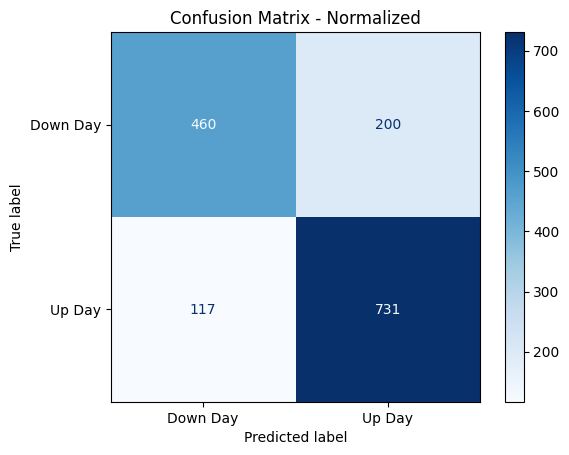

In [273]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


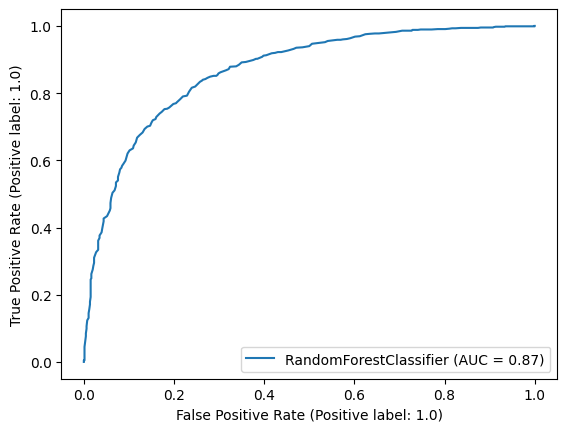

In [274]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [100]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [275]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 80.69%

Precisão do modelo nos últimos 30 dias: 65.00%


#### Plotagem:

In [276]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

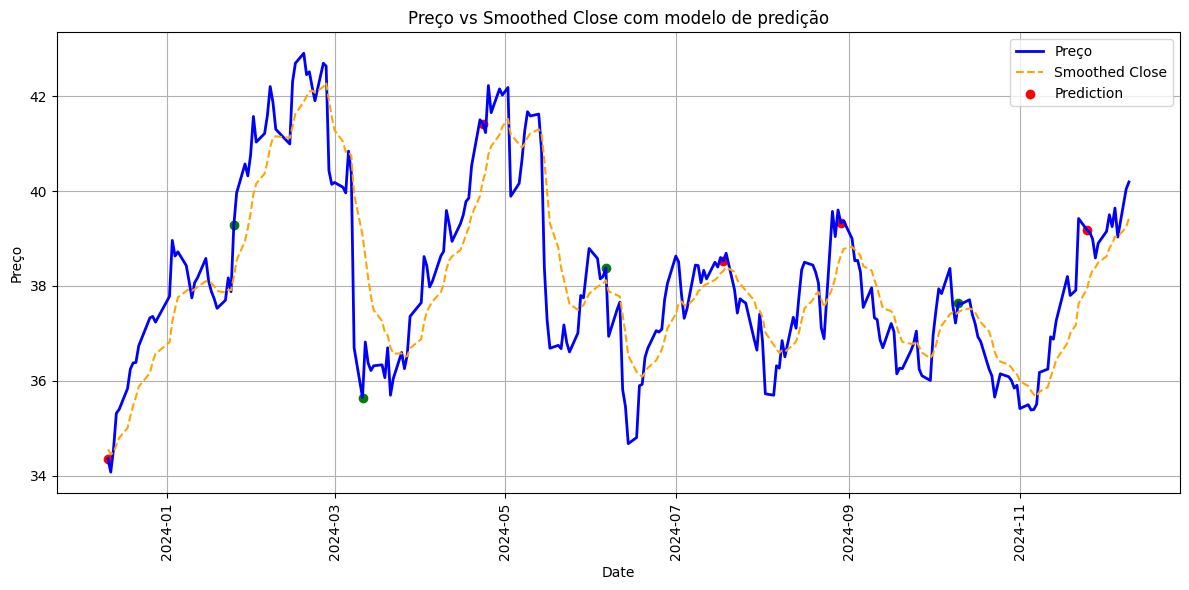

In [277]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):  
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [278]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5770,2000-02-04,3.750000,3.891666,3.750000,3.891666,1.694520,345600,VALE3.SA,0.141666,3.879920,-1.0,3.891666,-1.0,3.291666,3.120391,0.000000,0.141666,52.400509,3.708333,4.166666,37.437162,-62.562838,0.044518,0.045051,0.108549,16584000,1
5771,2000-02-07,3.916666,4.083333,3.916666,4.083333,1.777976,81600,VALE3.SA,0.191667,3.920603,-1.0,4.083333,-1.0,3.191666,3.134646,0.000000,0.191667,65.750992,3.708333,4.166666,46.313377,-53.686623,0.043158,0.044672,0.125532,16665600,1
5772,2000-02-08,4.083333,4.320833,4.083333,4.320833,1.881389,1036800,VALE3.SA,0.237500,4.000649,-1.0,4.320833,-1.0,3.251666,3.158050,0.000000,0.237500,75.554120,3.708333,4.320833,47.724987,-52.275013,0.046960,0.045130,0.152925,17702400,1
5773,2000-02-09,4.258333,4.366666,4.250000,4.250000,1.850546,6081600,VALE3.SA,-0.070833,4.050519,1.0,4.250000,-1.0,3.248333,3.176106,0.070833,0.000000,68.779335,3.708333,4.366666,51.977646,-48.022354,0.052740,0.046652,0.162495,23784000,0
5774,2000-02-10,4.250000,4.250000,4.000000,4.000000,1.741691,3969600,VALE3.SA,-0.250000,4.040415,-1.0,4.000000,-1.0,3.333333,3.207552,0.250000,0.000000,50.381726,3.708333,4.366666,50.442893,-49.557107,0.055912,0.048504,0.136822,19814400,1


In [279]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5757
  Accuracy with Verify: 0.5436
Fold 2:
  Accuracy with Y_test (Prediction): 0.5246
  Accuracy with Verify: 0.4915
Fold 3:
  Accuracy with Y_test (Prediction): 0.4664
  Accuracy with Verify: 0.4283
Fold 4:
  Accuracy with Y_test (Prediction): 0.5838
  Accuracy with Verify: 0.5266
Fold 5:
  Accuracy with Y_test (Prediction): 0.5707
  Accuracy with Verify: 0.5055

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5442
  Média da acurácia com Verify: 0.4991

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2           -1.0              1.0     1.0
3           -1.0              1.0     1.0
4           -1.0              1.0     1.0
...          ...              ...     ...
4980         1.0             -1.0    -1.0
4981         1.0             -1.0    -1.0
4982         1.0             -1.0    -1.0
4983         1.0              1.0    -

#### Walk-Forward Validation

In [280]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [281]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.40
  Accuracy with Verify: 0.41
Window 2:
  Accuracy with Y_test (Prediction): 0.61
  Accuracy with Verify: 0.59
Window 3:
  Accuracy with Y_test (Prediction): 0.39
  Accuracy with Verify: 0.44
Window 4:
  Accuracy with Y_test (Prediction): 0.42
  Accuracy with Verify: 0.36
Window 5:
  Accuracy with Y_test (Prediction): 0.84
  Accuracy with Verify: 0.81
Window 6:
  Accuracy with Y_test (Prediction): 0.57
  Accuracy with Verify: 0.43
Window 7:
  Accuracy with Y_test (Prediction): 0.40
  Accuracy with Verify: 0.42
Window 8:
  Accuracy with Y_test (Prediction): 0.77
  Accuracy with Verify: 0.72
Window 9:
  Accuracy with Y_test (Prediction): 0.66
  Accuracy with Verify: 0.67
Window 10:
  Accuracy with Y_test (Prediction): 0.61
  Accuracy with Verify: 0.60
Window 11:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.54
Window 12:
  Accuracy with Y_test (Prediction): 0.69
  Accuracy with Verify: 0.66
Window 13:
  Accuracy wit

#### Split normal sem cross-validation.

In [282]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [283]:
# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators = 220, oob_score = True, criterion = "gini", random_state = 0,n_jobs=-1)

# Fit the data to the model
rand_frst_clf_Vale.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Vale.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Vale.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  80.01336898395722


In [284]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.803704,0.692185,0.743787,627.000000
Up Day,0.798117,0.878021,0.836164,869.000000
accuracy,0.800134,0.800134,0.800134,0.800134
macro avg,0.800910,0.785103,0.789976,1496.000000
weighted avg,0.800459,0.800134,0.797448,1496.000000


Accuracy: 0.8001336898395722
Precision: 0.7981171548117155
Recall: 0.8780207134637514
Specificity: 0.6921850079744817
F1-Score: 0.8362


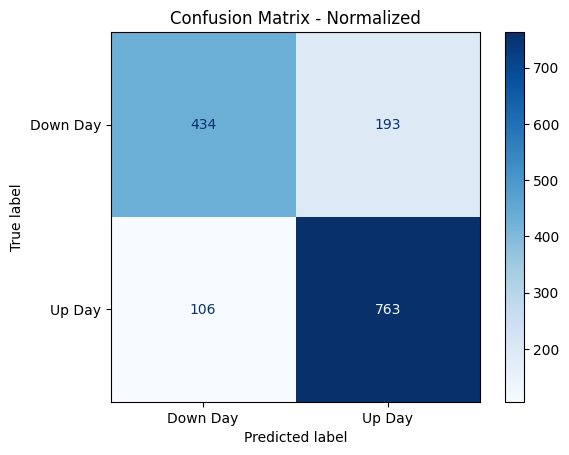

In [285]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


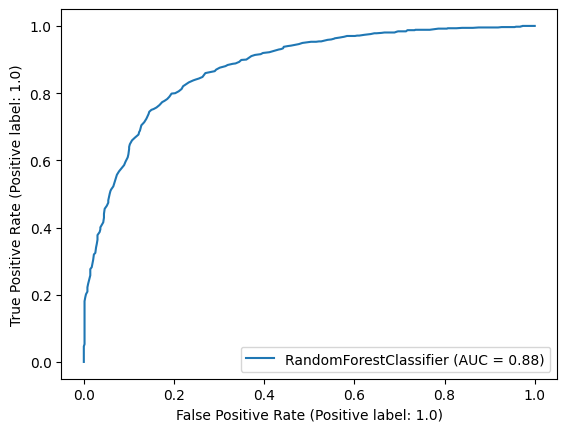

In [286]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [113]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [287]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 80.78%

Precisão do modelo nos últimos 30 dias: 95.00%


#### Plotagem:

In [288]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

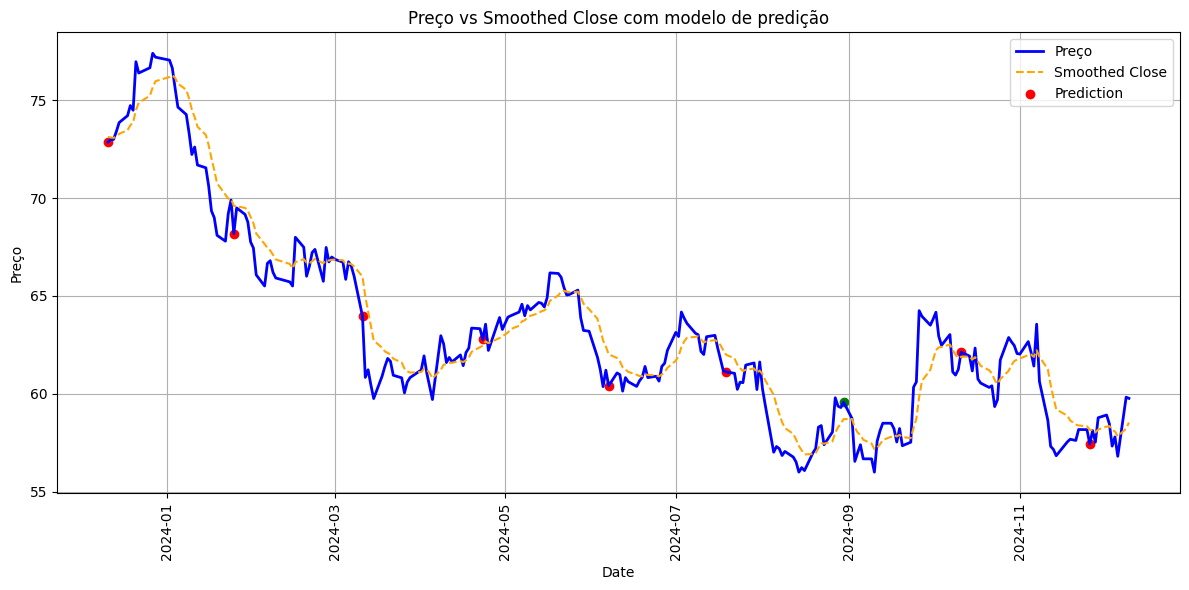

In [289]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 30):  
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
